# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn import tree
from sklearn import metrics






import warnings
warnings.filterwarnings("ignore")


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Read file

In [2]:
#Read and fast visualize the data 
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
df = pd.read_csv("clean_housing_data.csv")
print("Shape: ",df.shape)
df.head()

Shape:  (57007, 21)


,yearMonth_sale,case_type_dk,zip_code_name,erts89_utm32_x,erts89_utm32_y,ed50_x,ed50_y,wgs84_lat,wgs84_lon,residental_area,measured_area,energy_labeled_required,energy_labeled,amount_of_toilets,year_of_construction,renovation_year,first_offer_price,lastest_announced_price,sold_price,days_on_the_market_all_broker,change_broker
0,201805,Rækkehus,København Ø,724656.3099617342,6177510.129902037,724738.3771995398,6177716.274317907,"55,69125957","12,57452761",121,136.0,True,c,2,1882,0,9895000,9500000,8500000,79,0
1,201805,Rækkehus,København Ø,724612.6998841494,6177539.480294425,724694.7669242901,6177745.625006782,"55,69154296","12,57385928",136,151.0,True,c,2,1882,1,9595000,9195000,8750000,96,0
2,202006,Villa,København S,726339.2701369224,6172005.4193364065,726421.3337691108,6172211.5248479135,"55,64111328","12,59671021",107,126.0,True,d,1,1927,0,4195000,3995000,3900000,148,0
3,202103,Villa,København S,726314.7447286966,6171972.668490626,"726396,8081",6172178.773859339,"55,64083099","12,5962944",140,136.0,True,a,2,2017,0,7495000,7495000,7595000,17,0
4,201108,Villa,Brønshøj,718735.9998927611,6178448.999985718,718818.0324674495,6178655.165567457,"55,70238375","12,48127579",87,259.0,True,g,2,1928,0,2250000,2250000,2275000,15,0


# Prepare data for train_test_split

In [3]:
# For the moment we will not use the latitude and longitud
excluded_cols = ["erts89_utm32_x", "erts89_utm32_y", "ed50_x",
                 "ed50_y", "wgs84_lat", "wgs84_lon"]

#Drop those columns from the data set - IN CASE WE USE THEM DELETE THIS CELL
df = df.drop(excluded_cols, axis=1)





In [4]:
#experimental df to use later on
df_prompt= pd.read_csv("clean_housing_data.csv")
df_prompt = df_prompt.drop(excluded_cols, axis=1)
df_prompt = df_prompt.drop("sold_price", axis=1)

# Get dummies for categorical values

We need to check if there are any categorical features that need hot encoding for some of the machine learning models. 
One way to do this is by checking the data types of the columns:

In [5]:

#Find Categorical columns & save them in a variable
categorical_cols = [col for col in df.columns if df[col].dtype == "object"]

#Get dummies for those categorical columns
if categorical_cols:
    df = pd.get_dummies(df, columns=categorical_cols)

#Print the new shape of DF with dummies
print("This is the shape with the dummies:", df.shape)

This is the shape with the dummies: (57007, 37)


# Split data

In [6]:
#Save feature data in X
X = df.drop("sold_price", axis=1)

#Save target in y
y = df["sold_price"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y , random_state=42)


# Scaled data

First, The standard scaler is created in case it lead to better results

In [7]:

# Creating the scaler variable
scaler = StandardScaler()
#the scaler needs to be trained only in the training data and not in the test data, so it needs to be fit in there.
# What this will do is to adapt to all the values from the training set and create the new parameters dividing 
# all the numbers by the Max number found in the trianig data set
scaler.fit(X_train)

# Once the scaler variable has all the relative numbers, i can transform all the features so my new X_train_scaled will 
# only have numbers potencially between 0-1. On the test data we might find numbers higher than one or just smaller since 
# it will be divided by the higher number in the trainig set
X_train_standard_scaled = scaler.transform(X_train)
X_test_standard_scaled = scaler.transform(X_test) 

MinMax scaler

In [8]:
#Creating the MinMax scaler
scaler2= MinMaxScaler()

#Fitting to the training feature data
scaler2.fit(X_train)

#Transforming the feature training and testing data
X_train_MinMax_scaled=scaler2.transform(X_train)
X_test_MinMax_scaled=scaler2.transform(X_test)

# Functions

### Print Linear regression score, incercept & coeff

In [9]:

def print_model_scores(model, X_train, y_train, X_test, y_test):
    # Training set scores
    train_score = model.score(X_train, y_train)
  
    print("Training Set Score: {:.3f}".format(train_score))
    
    # Test set scores
    test_score = model.score(X_test, y_test)
   
    print("Test Set Score: {:.3f}".format(test_score))


    #coeficient of the model
    print("Linear model coeff (w):{}".format(model.coef_))

    #Intercept of the model
    print("Linear model intercept (b): {:.3f}".format(model.intercept_))
   


# Simple Linear regression model
This simple least squared regression has no way to control the model complexity 

### Non Scaled data with a fast evaluation

In [10]:
#Creating the model and fitting it in the non-scaled data
linear_reg=LinearRegression().fit(X_train, y_train)


In [11]:
#Using function to print training and test score
print_model_scores(linear_reg, X_train, y_train, X_test, y_test)

Training Set Score: 0.755
Test Set Score: 0.709
Linear model coeff (w):[ 5.51405051e+01 -1.63939793e+02  6.38642609e+02 -1.69237017e+05
 -1.51024068e+04  3.89125241e+02  1.41201026e+03 -6.92313822e-02
  1.02202586e+00 -2.87412877e+02  3.23822677e+04 -2.76184144e+02
 -5.99751119e+04  1.68781360e+04  4.33731600e+04 -6.50600187e+03
 -2.43804929e+03  2.34802588e+04  1.61484757e+05  2.29372005e+04
  9.31722977e+03 -3.11748708e+02 -1.68197204e+04  2.45839634e+04
  2.58655841e+04 -1.44001830e+05 -9.65819908e+04 -5.42392513e+03
  4.41427224e+03  1.84825237e+05 -3.88108798e+03 -2.00008498e+04
 -2.19612091e+04 -2.68386463e+04 -3.98976158e+04 -7.22458276e+04]
Linear model intercept (b): -11624262.920


### Scaled data with a fast evaluation

Standard scaled data

In [12]:
#Creating the model and fitting it in the scaled data
linear_reg_scaled=LinearRegression().fit(X_train_standard_scaled,y_train)

In [13]:
#Using function to print training and test score for the scaled data
print_model_scores(linear_reg_scaled, X_train_standard_scaled, y_train, X_test_standard_scaled, y_test) 

Training Set Score: 0.755
Test Set Score: 0.709
Linear model coeff (w):[ 1.67465733e+04 -6.15411058e+03  2.70470281e+04 -3.90311936e+04
 -6.45557865e+03  1.61254199e+04  4.78753310e+02 -1.51322128e+05
  2.20094931e+06 -3.40848525e+04  1.07091064e+04 -1.21050434e+03
 -1.12656984e+04  4.28193544e+03  6.82435201e+03 -5.53593478e+03
 -1.82637251e+03  1.18329271e+02  3.45560502e+04  1.91466604e+03
 -1.62032262e+03 -7.32756341e+03 -7.07937296e+03  2.03284399e+03
  3.51943762e+03 -1.28910745e+04 -1.21850956e+03 -6.44942215e+03
 -3.07379367e+03  4.30822302e+04  1.04112285e+03 -5.21737141e+03
 -7.04307460e+03 -6.79643569e+03 -5.77848087e+03 -6.91219933e+03]
Linear model intercept (b): 3295349.405


MinMax Scaled Data

In [14]:
#Creating the model and fitting it in the scaled data
linear_reg_MinMax_scaled=LinearRegression().fit(X_train_MinMax_scaled,y_train)

In [15]:
#Using function to print training and test score for the scaled data
print_model_scores(linear_reg_MinMax_scaled,X_train_MinMax_scaled,y_train,X_test_MinMax_scaled,y_test)

Training Set Score: 0.755
Test Set Score: 0.709
Linear model coeff (w):[ 6.09302580e+04 -8.34526910e+04  3.87562937e+05 -1.70880094e+05
 -8.11475217e+04  1.24999068e+05  1.33008295e+03 -3.78257626e+06
  5.61579569e+07 -5.26122399e+05  3.47933101e+04  8.59147574e+16
  8.59147574e+16  8.59147574e+16  8.59147574e+16 -1.79261191e+18
 -1.79261191e+18 -1.79261191e+18 -1.79261191e+18 -1.79261191e+18
 -1.79261191e+18 -1.79261191e+18 -1.79261191e+18 -1.79261191e+18
 -1.79261191e+18 -1.79261191e+18 -1.79261191e+18 -1.79261191e+18
 -1.79261191e+18  1.32545872e+17  1.32545872e+17  1.32545872e+17
  1.32545872e+17  1.32545872e+17  1.32545872e+17  1.32545872e+17]
Linear model intercept (b): 1574151284136490240.000


### Plotting the non standar 

In [16]:
predictions = linear_reg.predict(X_test_MinMax_scaled) 

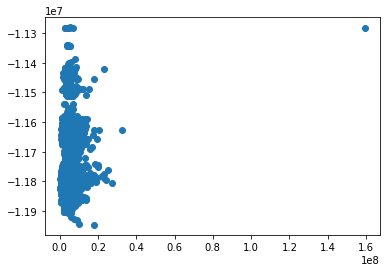

In [17]:
plt.scatter(y_test,predictions)

<AxesSubplot:xlabel='sold_price', ylabel='Density'>

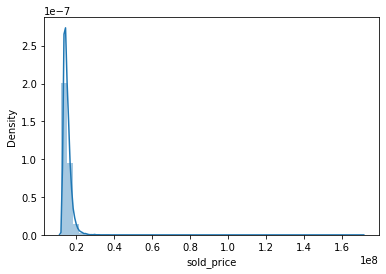

In [18]:
sns.distplot((y_test-predictions),bins=50)

### Use of Cross validation   --->> CHEQUEAR !!!!!!!!!! 

In [19]:
# Perform cross-validation
scores = cross_val_score(linear_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert the scores to positive values
mse_scores = -scores

# Print the mean and standard deviation of the scores
print("Mean MSE:", mse_scores.mean())
print("Standard Deviation:", mse_scores.std())

Mean MSE: 1419900498723.0469
Standard Deviation: 1698761849282.0327


# Ridge Regression model  

### Different Ridge models with no regularization

In [20]:
#Create & fit model for the 3 different type of scaled data
ridge_reg=Ridge().fit(X_train, y_train)
ridge_reg_stand=Ridge().fit(X_train_standard_scaled, y_train)
ridge_reg_MinMax=Ridge().fit(X_train_MinMax_scaled, y_train)

In [21]:
print_model_scores(ridge_reg,X_train,y_train,X_test,y_test)
print_model_scores(ridge_reg_stand,X_train_standard_scaled,y_train,X_test_standard_scaled,y_test)
print_model_scores(ridge_reg_MinMax,X_train_MinMax_scaled,y_train,X_test_MinMax_scaled,y_test)

Training Set Score: 0.755
Test Set Score: 0.709
Linear model coeff (w):[ 5.51432234e+01 -1.63686976e+02  6.38458000e+02 -1.69174346e+05
 -1.51146908e+04  3.89315500e+02  1.41724636e+03 -6.92454191e-02
  1.02204341e+00 -2.87397120e+02  3.23659949e+04 -2.90573387e+02
 -5.98619159e+04  1.68397350e+04  4.33127543e+04 -7.57054503e+03
 -3.50581307e+03  2.04570895e+04  1.60362217e+05  2.18568215e+04
  8.24001913e+03 -1.37369283e+03 -1.78687119e+04  2.35114376e+04
  2.47861214e+04 -1.44394116e+05 -8.13495365e+04 -6.48884346e+03
  3.33755280e+03  1.84629402e+05 -3.91454612e+03 -1.99985498e+04
 -2.19492288e+04 -2.68255446e+04 -3.98646448e+04 -7.20768876e+04]
Linear model intercept (b): -11624158.762
Training Set Score: 0.755
Test Set Score: 0.709
Linear model coeff (w):[ 1.67183222e+04 -6.07626284e+03  2.69705861e+04 -3.90828362e+04
 -6.43056424e+03  1.61445829e+04  4.73956663e+02 -1.34713721e+05
  2.18432190e+06 -3.45524123e+04  1.09552707e+04 -1.19640784e+03
 -1.12523429e+04  4.25467663e+03  6

In [22]:
#Put the coefficients into a data frame for a better visualization
coeff_df = pd.DataFrame(ridge_reg_MinMax.coef_,X.columns,columns=['Coefficient']) 
coeff_df



,Coefficient
yearMonth_sale,1.325106e+05
residental_area,5.082155e+05
measured_area,5.340728e+05
energy_labeled_required,-1.847427e+05
amount_of_toilets,-6.513596e+03
year_of_construction,1.056069e+05
renovation_year,2.605022e+02
first_offer_price,2.231422e+07
lastest_announced_price,2.798626e+07
days_on_the_market_all_broker,-9.940975e+05


### Ridge with regularization L2

In [23]:


print("Ridge regression: effect of alpha regularization parameter\n")

resList = []
for alpha in [0.001,0.01, 0.1, 0.3, 1, 100, 200, 300, 1000, 3000]:
    clf = Ridge(alpha=alpha, random_state=0).fit(X_train, y_train)
    predictions = clf.predict(X_test)  
    res = (clf.score(X_test, y_test), clf.score(X_train, y_train),metrics.mean_absolute_error(y_test, predictions),metrics.mean_squared_error(y_test, predictions),np.sqrt(metrics.mean_squared_error(y_test, predictions)), alpha)
    resList.append(res)
    coeff_num= np.sum(abs(clf.coef_)) #sum all the coefficients to see if the alpha push it to zero, therefore, simplier model. 
   
resListSrt = sorted (resList,
                key = lambda e:e[0], reverse=True)

# Create a list of column names for the DataFrame
columns_results = ["Test", "Train", "MAE", "MSE", "RMSE", "alpha"]

# Create an empty DataFrame
df_results0 = pd.DataFrame(columns=columns_results)

for r in resListSrt:
    # Create a dictionary representing each row of data
    row = {
        "Test": r[0],
        "Train": r[1],
        "MAE": r[2],
        "MSE": r[3],
        "RMSE": r[4],
        "alpha": r[5]
    }
    # Append the row to the DataFrame
    df_results0 = df_results0.append(row, ignore_index=True)

# Print the DataFrame
df_results0






Ridge regression: effect of alpha regularization parameter



,Test,Train,MAE,MSE,RMSE,alpha
0,0.709281,0.754707,104720.278528,1745278571120.050781,1321089.917878,0.001
1,0.709281,0.754707,104720.182681,1745278609248.444336,1321089.932309,0.01
2,0.709281,0.754707,104719.223145,1745278987761.556641,1321090.075567,0.1
3,0.70928,0.754707,104717.087049,1745279811596.176025,1321090.387368,0.3
4,0.70928,0.754707,104710.062656,1745282530336.033447,1321091.416343,1.0
5,0.709244,0.754702,103772.109132,1745500384629.837891,1321173.866162,100.0
6,0.709211,0.754693,102994.713715,1745694700294.001465,1321247.403136,200.0
7,0.709181,0.754683,102326.996437,1745874831751.61084,1321315.568572,300.0
8,0.709009,0.754605,99270.394772,1746908803395.635986,1321706.776632,1000.0
9,0.708698,0.754416,95997.373552,1748779366253.331787,1322414.218864,3000.0


In [24]:

print("Ridge regression Standard scaled data: effect of alpha regularization parameter\n")


resList = []
for alpha in [0.001,0.01, 0.1, 0.3, 1, 100, 200, 300, 1000, 3000]:
    clf = Ridge(alpha=alpha, random_state=0).fit(X_train_standard_scaled, y_train)
    predictions = clf.predict(X_test)  
    res = (clf.score(X_test_standard_scaled, y_test), clf.score(X_train_standard_scaled, y_train),metrics.mean_absolute_error(y_test, predictions),metrics.mean_squared_error(y_test, predictions),np.sqrt(metrics.mean_squared_error(y_test, predictions)), alpha)
    resList.append(res)
    coeff_num= np.sum(abs(clf.coef_)) #sum all the coefficients to see if the alpha push it to zero, therefore, simplier model. 
   
resListSrt = sorted (resList,
                key = lambda e:e[0], reverse=True)


# Create an empty DataFrame
df_results1 = pd.DataFrame(columns=columns_results)

for r in resListSrt:
    # Create a dictionary representing each row of data
    row = {
        "Test": r[0],
        "Train": r[1],
        "MAE": r[2],
        "MSE": r[3],
        "RMSE": r[4],
        "alpha": r[5]
    }
    # Append the row to the DataFrame
    df_results1 = df_results1.append(row, ignore_index=True)

# Print the DataFrame
df_results1




Ridge regression Standard scaled data: effect of alpha regularization parameter



,Test,Train,MAE,MSE,RMSE,alpha
0,0.709282,0.754706,6904592297346.71875,66817495636835048913633280.0,8174196941402.56543,1.0
1,0.709281,0.754707,6903975183983.382812,66806355035194089227157504.0,8173515463690.888672,0.3
2,0.709281,0.754707,6903795589336.750977,66803112520750121393061888.0,8173317106337.555664,0.1
3,0.709281,0.754707,6903714289866.158203,66801644643288381103538176.0,8173227308920.77832,0.01
4,0.709281,0.754707,6903706143397.81543,66801497555712533864644608.0,8173218310782.633789,0.001
5,0.709075,0.754433,6918333476481.423828,67042745321578315598790656.0,8187963441636.651367,100.0
6,0.708937,0.754262,6894427093741.540039,66569084719420653225115648.0,8158987971520.772461,200.0
7,0.708854,0.754156,6863925226642.451172,65974484501614138056769536.0,8122467882461.225586,300.0
8,0.708484,0.753639,6637795210172.935547,61669742328451854462091264.0,7853008489009.282227,1000.0
9,0.706813,0.751463,6109072299586.571289,52185016195834853342576640.0,7223919725179.319336,3000.0


In [25]:
print("Ridge regression MinMax Scaled data: effect of alpha regularization parameter\n")

resList = []
for alpha in [0.001,0.01, 0.1, 0.3, 1, 100, 200, 300, 1000, 3000]:
    clf = Ridge(alpha=alpha, random_state=0).fit(X_train_MinMax_scaled, y_train)
    predictions = clf.predict(X_test)  
    res = (clf.score(X_test_MinMax_scaled, y_test), clf.score(X_train_MinMax_scaled, y_train),metrics.mean_absolute_error(y_test, predictions),metrics.mean_squared_error(y_test, predictions),np.sqrt(metrics.mean_squared_error(y_test, predictions)), alpha)
    resList.append(res)
    coeff_num= np.sum(abs(clf.coef_)) #sum all the coefficients to see if the alpha push it to zero, therefore, simplier model. 
   
resListSrt = sorted (resList,
                key = lambda e:e[0], reverse=True)





# Create an empty DataFrame
df_results2 = pd.DataFrame(columns=columns_results)

for r in resListSrt:
    # Create a dictionary representing each row of data
    row = {
        "Test": r[0],
        "Train": r[1],
        "MAE": r[2],
        "MSE": r[3],
        "RMSE": r[4],
        "alpha": r[5]
    }
    # Append the row to the DataFrame
    df_results2 = df_results2.append(row, ignore_index=True)

# Print the DataFrame
df_results2




Ridge regression MinMax Scaled data: effect of alpha regularization parameter



,Test,Train,MAE,MSE,RMSE,alpha
0,0.709282,0.754701,176361223787548.59375,43600077394346411927724359680.0,208806315503977.0625,0.01
1,0.709281,0.754706,176359508509965.59375,43603221689488381848334630912.0,208813844582892.5,0.001
2,0.709148,0.754521,176095106652455.9375,43450570862698375223070162944.0,208448005178026.0625,0.1
3,0.708937,0.75426,175022591252670.6875,42913669185278260674719383552.0,207156146868197.625,0.3
4,0.708657,0.753875,170868528225157.34375,40894655464456972148664172544.0,202224270216156.21875,1.0
5,0.636776,0.667641,53096018925527.351562,3934134703456458286651408384.0,62722680933267.335938,100.0
6,0.598018,0.623427,36306725534570.4375,1835321289947925545255698432.0,42840649971118.851562,200.0
7,0.568506,0.590597,28535338610690.585938,1131657291161259469524959232.0,33640114315520.085938,300.0
8,0.458144,0.471345,12813782282978.863281,226337866174752502130409472.0,15044529443447.292969,1000.0
9,0.34479,0.352642,5646543601985.118164,43529203457971199642959872.0,6597666516123.044922,3000.0


# Random Forest

### Basic Random Forest

In [26]:
# Create a random forest regressor & Fit 
rf_model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)

In [27]:
# Make predictions on the testing data
y_pred = rf_model.predict(X_test)

# Calculate mean squared error
mse = metrics.mean_squared_error(y_test, y_pred)

# Calculate R-squared
r2 = metrics.r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Training Score", rf_model.score(X_train, y_train))
print("Test score;", rf_model.score(X_test,y_test))

Mean Squared Error: 2297865669836.418
R-squared: 0.6172336240469303
Training Score 0.9429654562090818
Test score; 0.6172336240469303


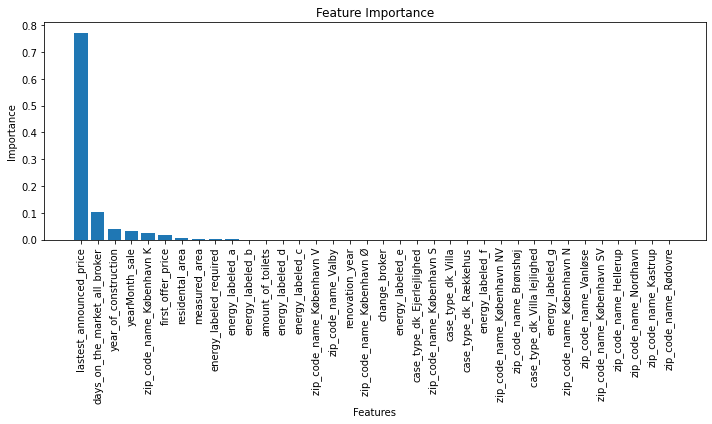

In [314]:
# Get feature importances
importances = rf_model.feature_importances_

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()


### Model optimization and regularization

In [316]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


### Create a new model with the optimized values 

In [54]:
 # Create a random forest regressor & Fit 
rf_model = RandomForestRegressor(n_estimators=300, min_samples_leaf=4, max_depth=5, min_samples_split=10, random_state=42).fit(X_train, y_train)

In [29]:
# Make predictions on the testing data
y_pred = rf_model.predict(X_test)

# Calculate mean squared error
mse = metrics.mean_squared_error(y_test, y_pred)

# Calculate R-squared
r2 = metrics.r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Training Score", rf_model.score(X_train, y_train))
print("Test score;", rf_model.score(X_test,y_test))

Mean Squared Error: 1876967335596.2356
R-squared: 0.6873446545377888
Training Score 0.7813686893535733
Test score; 0.6873446545377888


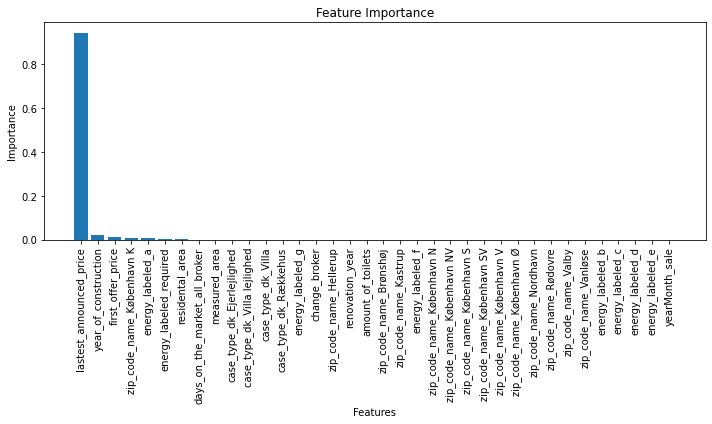

In [30]:
# Get feature importances
importances = rf_model.feature_importances_

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

#### Same model for different scaled data

In [60]:
 # Create a random forest regressor & Fit for Standard scaled data
rf_model = RandomForestRegressor(n_estimators=300, min_samples_leaf=4, max_depth=5, min_samples_split=10, random_state=42).fit(X_train_standard_scaled, y_train)

# Make predictions on the testing data
y_pred = rf_model.predict(X_test_standard_scaled)

# Calculate mean squared error
mse = metrics.mean_squared_error(y_test, y_pred)

# Calculate R-squared
r2 = metrics.r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Training Score", rf_model.score(X_train_standard_scaled, y_train))
print("Test score;", rf_model.score(X_test_standard_scaled,y_test))

Mean Squared Error: 1876924947492.5635
R-squared: 0.687351715325127
Training Score 0.7813685487144494
Test score; 0.687351715325127


In [58]:
 # Create a random forest regressor & Fit for MinMax scaled data
rf_model = RandomForestRegressor(n_estimators=300, min_samples_leaf=4, max_depth=5, min_samples_split=10, random_state=42).fit(X_train_MinMax_scaled, y_train)

# Make predictions on the testing data
y_pred = rf_model.predict(X_test_MinMax_scaled)

# Calculate mean squared error
mse = metrics.mean_squared_error(y_test, y_pred)

# Calculate R-squared
r2 = metrics.r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Training Score", rf_model.score(X_train_MinMax_scaled, y_train))
print("Test score;", rf_model.score(X_test_MinMax_scaled,y_test))

Mean Squared Error: 1876955879956.2808
R-squared: 0.6873465627580331
Training Score 0.7813703877618895
Test score; 0.6873465627580331


#### Random forest comparison of scores with different n-estimators 

##### With non-scaled data

In [66]:
n=list(range(20,500,20))

train_scores=[]
test_scores=[]
j=0

for i in n:
    
    clf_rf=RandomForestClassifier(n_estimators=i, min_samples_leaf=4, max_depth=5, min_samples_split=10, random_state=42).fit(X_train,y_train)
    train_scores.append(clf.score(X_train,y_train))
    test_scores.append(clf.score(X_test,y_test))
    print ("{})  For n_estimators = {}, the train score is : {:.3f} and the test score is: {:.3f} \n".format(j+1 ,n[j], train_scores[j], test_scores[j]))
    j+=1



1)  For n_estimators = 20, the train score is : -7521856946585.565 and the test score is: -7250865737906.813 



In [ ]:
# Plot the test results


# x axis - a list of the values for number of estimators
x = n
# two arguments to plot are the x axis values and the y axis values
# y axis - list of test scores
plt.plot(x, test_scores)
# finally, to show the plots
plt.show()


# Plot the difference between training scores and testing scores

# x axis - a list of the values for number of estimators
x = n
# y axis - list of train scores
# two arguments to plot are the x axis values and the y axis values
plt.plot(x , test_scores)
# do another plot, with same x axis, and on the y axis - list of test scores
plt.plot(x,train_scores)
# finally, to show the plots
plt.show()

##### With standard scaled data

In [ ]:
n=list(range(20,500,20))

train_scores=[]
test_scores=[]
j=0

for i in n:
    
    clf_rf_scaled=RandomForestClassifier(n_estimators=i, min_samples_leaf=4, max_depth=5, min_samples_split=10, random_state=42).fit(X_train_standard_scaled,y_train)
    train_scores.append(clf.score(X_train_standard_scaled,y_train))
    test_scores.append(clf.score(X_test_standard_scaled,y_test))
    print ("{})  For n_estimators = {}, the train score is : {:.3f} and the test score is: {:.3f} \n".format(j+1 ,n[j], train_scores[j], test_scores[j]))
    j+=1

In [ ]:
#Plot the results for scaled data

# x axis - a list of the values for number of estimators
x = n
# two arguments to plot are the x axis values and the y axis values
# y axis - list of test scores
plt.plot(x, test_scores)
# finally, to show the plots
plt.show()

# Neural Networks: Multilayer Perceptron (MLP)

In [ ]:
# This is the list with the units of each different for the sizes of the hidden layers
units = list(range(1,20,5))

#I create empty lists where i will save the results of MLP for the different combinations of hidden layers with NON-scaled data
mlp1_train_score=list()
mlp1_test_score=list()
mlp2_train_score=list()
mlp2_test_score=list()




# Just printing a title
print("For the MLP model fit in the NON-scaled data with a SINGLE layer and different hidden sizes the results are:\n") 
print(" Size Layer 1   -   Size Layer 2  -  Train Score  -   Test Score   -   Train Scaled   -   Test Scaled")

# A loop where the MLP classifier will be fit with the different units for the NON-scaled data
for i in units: 
        for n in units: 
                #Not scaled data
        
                mlp1clf=MLPRegressor(hidden_layer_sizes= (i, n), random_state=42).fit(X_train,y_train)

                # I add to the list each of the scores of the iteration

                mlp1_train_score.append(mlp1clf.score(X_train,y_train))
                mlp1_test_score.append(mlp1clf.score(X_test,y_test))
                

                

                #Scaled data

                mlp2clf=MLPRegressor(hidden_layer_sizes= (i, n), random_state=42).fit(X_train_standard_scaled,y_train)

                # I add to the list each of the scores of the iteration

                mlp2_train_score.append(mlp2clf.score(X_train_standard_scaled,y_train))
                mlp2_test_score.append(mlp2clf.score(X_test_standard_scaled,y_test))
                

                #While looping printing the results 
                print("{:13.0f}{:19.0f}{:16.3f}{:16.3f}{:16.3f}{:16.3f}".format(i,n,mlp1clf.score(X_train,y_train), mlp1clf.score(X_test,y_test), mlp2clf.score(X_train_standard_scaled,y_train), mlp2clf.score(X_test_standard_scaled,y_test)))


In [ ]:
# x axis - a list of the values for number of estimators
x=units
# y axis - list of train scores
# two arguments to plot are the x axis values and the y axis values
plt.plot(x,mlp1_train_score)
# do another plot, with same x axis, and on the y axis - list of test scores
plt.plot(x,mlp1_test_score)
# finally need to show the plots

plt.show()

In [ ]:
# x axis - a list of the values for number of estimators
x=units
# y axis - list of train scores
# two arguments to plot are the x axis values and the y axis values
plt.plot(x,mlp2_train_score)
# do another plot, with same x axis, and on the y axis - list of test scores
plt.plot(x,mlp2_test_score)
# finally need to show the plots

plt.show()

In [2]:
#For Min Max scaled data


#I create empty lists where i will save the results of MLP for the different combinations of hidden layers with SCALED data
mlp3_train_score=list()
mlp3_test_score=list()


# Just printing a title
print("\n\nFor the MLP model fit in the SCALED MinMax data with a SINGLE layer and different hidden sizes the results are:\n") 
print(" Size Layer 1   -   Size Layer 2  -  Train Score  -   Test Score")

# A loop where the MLP classifier will be fit with the different units for the SCALED MinMax data
# I used the old units list
for i in units: 
        for n in units: 
        
                mlp3clf=MLPRegressor(hidden_layer_sizes= (i, n), random_state=42).fit(X_train_MinMax_scaled,y_train)

                # I add to the list each of the scores of the iteration

                mlp3_train_score.append(mlp3clf.score(X_train_MinMax_scaled,y_train))
                mlp3_test_score.append(mlp3clf.score(X_test_MinMax_scaled,y_test))
                

                #While looping printing the results 
                print("{:13.0f}{:19.0f}{:16.3f}{:16.3f}".format(i,n, mlp3clf.score(X_train_MinMax_scaled,y_train), mlp3clf.score(X_test_MinMax_scaled,y_test)))



For the MLP model fit in the SCALED MinMax data with a SINGLE layer and different hidden sizes the results are:

 Size Layer 1   -   Size Layer 2  -  Train Score  -   Test Score


NameError: name 'units' is not defined

In [3]:
# x axis - a list of the values for number of estimators
x=units
# y axis - list of train scores
# two arguments to plot are the x axis values and the y axis values
plt.plot(x,mlp3_train_score
# do another plot, with same x axis, and on the y axis - list of test scores
plt.plot(x,mlp3_test_score)
# finally need to show the plots

plt.show()

SyntaxError: invalid syntax (2292965754.py, line 7)

# Code to predict real house prices


In [4]:

# Create a dictionary with the feature values
new_sample = {
    "yearMonth_sale": 202301,
    "residental_area": 90,
    "measured_area": 150,
    "amount_of_toilets": 1 ,
    "year_of_construction": 1865, 
    "renovation_year": 0 ,
    "first_offer_price": 3495000, 
    "lastest_announced_price": 3295000 , 
    "days_on_the_market_all_broker": 180 , 
    "change_broker": 0, 
    'energy_labeled_required':0,
    'case_type_dk_Ejerlejlighed':0,
    'case_type_dk_Rækkehus':1,
    'case_type_dk_Villa':0,
    'case_type_dk_Villa lejlighed':0,
    'zip_code_name_Brønshøj':0,
    'zip_code_name_Hellerup':0,
    'zip_code_name_Kastrup':1,
    'zip_code_name_København K':0,
    'zip_code_name_København N':0,
    'zip_code_name_København NV':0,
    'zip_code_name_København S':0,
    'zip_code_name_København SV':0,
    'zip_code_name_København V':0,
    'zip_code_name_København Ø':0,
    'zip_code_name_Nordhavn':0,
    'zip_code_name_Rødovre':0,
    'zip_code_name_Valby':0,
    'zip_code_name_Vanløse':0,
    'energy_labeled_a':0,
    'energy_labeled_b':0,
    'energy_labeled_c':0,
    'energy_labeled_d':0,
    'energy_labeled_e':0,
    'energy_labeled_f':0,
    'energy_labeled_g':0

} 
#INFO FROM THE HOUSE :  3mil sold price --->  "case_type_dk": "Rækkehus"  ---> "zip_code_name": "Dragoer",---> "energy_labeled": "g", 

# Create a DataFrame from the new sample
new_sample_df = pd.DataFrame([new_sample])

# Perform one-hot encoding on categorical features
new_sample_encoded = pd.get_dummies(new_sample_df)

# Make a prediction on the new sample randome forest
predicted_price = rf_model.predict(new_sample_encoded)

print("Predicted Price Random forest:", predicted_price)

# Make a prediction on the new sample Linear regression
predicted_price1 = linear_reg_scaled.predict(new_sample_encoded)

print("Predicted Price Linear regressor:", predicted_price1)

NameError: name 'pd' is not defined

#### In order to prompt a new sample and predict the price 

In [ ]:
    

    "yearMonth_sale": 202301,
    "residental_area": 90,
    "measured_area": 150,
    "amount_of_toilets": 1 ,
    "year_of_construction": 1865, 
    "renovation_year": 1 ,
    "first_offer_price": 3495000, 
    "lastest_announced_price": 3295000 , 
    "days_on_the_market_all_broker": 180 , 
    "change_broker": 0, 
    'energy_labeled_required':0,
    'case_type_dk_Ejerlejlighed':0,
    'case_type_dk_Rækkehus':1,
    'case_type_dk_Villa':0,
    'case_type_dk_Villa lejlighed':0,
    'zip_code_name_Brønshøj':0,
    'zip_code_name_Hellerup':0,
    'zip_code_name_Kastrup':0,
    'zip_code_name_København K':0,
    'zip_code_name_København N':0,
    'zip_code_name_København NV':0,
    'zip_code_name_København S':0,
    'zip_code_name_København SV':0,
    'zip_code_name_København V':0,
    'zip_code_name_København Ø':0,
    'zip_code_name_Nordhavn':0,
    'zip_code_name_Rødovre':0,
    'zip_code_name_Valby':0,
    'zip_code_name_Vanløse':0,
    'energy_labeled_a':0,
    'energy_labeled_b':0,
    'energy_labeled_c':0,
    'energy_labeled_d':0,
    'energy_labeled_e':0,
    'energy_labeled_f':0,
    'energy_labeled_g':0
